In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sea 

In [2]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense,Dropout,ReLU,ELU,Activation,Flatten

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error

In [4]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore',category=DeprecationWarning)

In [5]:
from xgboost import XGBRegressor

In [6]:
df_train=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')

In [7]:
df_train.shape

(1460, 81)

In [8]:
df_test.shape

(1459, 80)

In [9]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
def get_combined_data():
    y=df_train['SalePrice']
    df_train.drop('SalePrice',axis=1,inplace=True)
    
    df=df_train.append(df_test)
    df.reset_index(inplace=True)
    df.drop(['index','Id'],inplace=True,axis=1)
    return y,df

In [11]:
y,df=get_combined_data()

In [12]:
df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,...,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,...,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,...,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,...,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,...,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,...,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [13]:
def get_cols_with_no_nans(df_final,col_type):
    if (col_type == 'num'):
        predictors = df_final.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df_final.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df_final
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df_final[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [14]:
num_cols = get_cols_with_no_nans(df , 'num')
cat_cols = get_cols_with_no_nans(df , 'no_num')

In [15]:
print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

Number of numerical columns with no nan values : 25
Number of nun-numerical columns with no nan values : 20


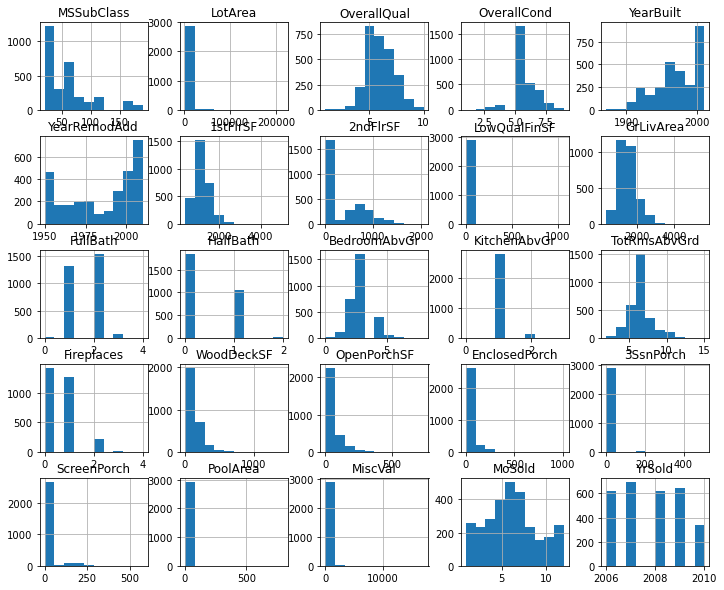

In [16]:
df = df[num_cols + cat_cols]
df.hist(figsize = (12,10))
plt.show()

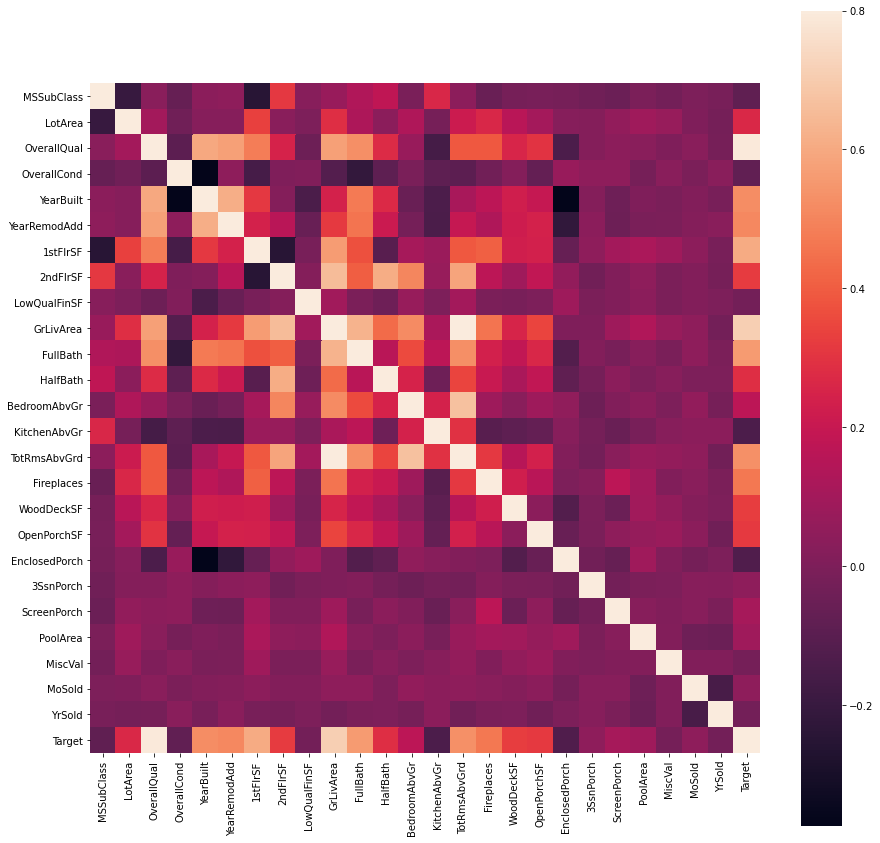

In [17]:
train_data = df[num_cols + cat_cols]
train_data['Target'] = y

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sea.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [18]:
def oneHotEncode(df2,colNames):
    for col in colNames:
        if( df2[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df2[col],prefix=col)
            df2 = pd.concat([df2,dummies],axis=1)

            #drop the encoded column
            df2.drop([col],axis = 1 , inplace=True)
    return df2

In [19]:
print('There were {} columns before encoding categorical features'.format(df.shape[1]))
df = oneHotEncode(df, cat_cols)
print('There are {} columns after encoding categorical features'.format(df.shape[1]))

There were 45 columns before encoding categorical features
There are 149 columns after encoding categorical features


In [20]:
df.shape

(2919, 149)

In [23]:
train = df[:1460]
test = df[1460:]

In [21]:
model=Sequential()

In [25]:
model.add(Dense(128,kernel_initializer='normal',input_dim=train.shape[1],activation='relu'))

In [26]:
model.add(Dense(256,kernel_initializer='normal',activation='relu'))
model.add(Dense(256,kernel_initializer='normal',activation='relu'))
model.add(Dense(256,kernel_initializer='normal',activation='relu'))

In [27]:
model.add(Dense(1, kernel_initializer='normal',activation='linear'))

In [28]:
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               19200     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 184,065
Trainable params: 184,065
Non-trainable params: 0
_________________________________________________________________


In [29]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [31]:
model.fit(train,y, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Epoch 1/500
37/37 [==============================] - 70s 161ms/step - loss: 166214.9301 - mean_absolute_error: 166214.9301 - val_loss: 53517.0391 - val_mean_absolute_error: 53517.0391

Epoch 00001: val_loss improved from inf to 53517.03906, saving model to Weights-001--53517.03906.hdf5
Epoch 2/500
37/37 [==============================] - 1s 27ms/step - loss: 60958.2042 - mean_absolute_error: 60958.2042 - val_loss: 47310.5938 - val_mean_absolute_error: 47310.5938

Epoch 00002: val_loss improved from 53517.03906 to 47310.59375, saving model to Weights-002--47310.59375.hdf5
Epoch 3/500
37/37 [==============================] - 1s 26ms/step - loss: 46805.8932 - mean_absolute_error: 46805.8932 - val_loss: 43585.8203 - val_mean_absolute_error: 43585.8203

Epoch 00003: val_loss improved from 47310.59375 to 43585.82031, saving model to Weights-003--43585.82031.hdf5
Epoch 4/500
37/37 [==============================] - 1s 27ms/step - loss: 43787.9299 - mean_absolute_error: 43787.9299 - val_loss: 

37/37 [==============================] - 1s 27ms/step - loss: 29536.3116 - mean_absolute_error: 29536.3116 - val_loss: 32982.4570 - val_mean_absolute_error: 32982.4570

Epoch 00032: val_loss improved from 33697.28906 to 32982.45703, saving model to Weights-032--32982.45703.hdf5
Epoch 33/500
37/37 [==============================] - 1s 27ms/step - loss: 29784.3996 - mean_absolute_error: 29784.3996 - val_loss: 33446.4727 - val_mean_absolute_error: 33446.4727

Epoch 00033: val_loss did not improve from 32982.45703
Epoch 34/500
37/37 [==============================] - 1s 27ms/step - loss: 29517.1338 - mean_absolute_error: 29517.1338 - val_loss: 33882.9531 - val_mean_absolute_error: 33882.9531

Epoch 00034: val_loss did not improve from 32982.45703
Epoch 35/500
37/37 [==============================] - 1s 26ms/step - loss: 30084.4985 - mean_absolute_error: 30084.4985 - val_loss: 34854.7188 - val_mean_absolute_error: 34854.7188

Epoch 00035: val_loss did not improve from 32982.45703
Epoch 36/5

37/37 [==============================] - 1s 27ms/step - loss: 26340.8262 - mean_absolute_error: 26340.8262 - val_loss: 32387.3145 - val_mean_absolute_error: 32387.3145

Epoch 00065: val_loss did not improve from 30178.00977
Epoch 66/500
37/37 [==============================] - 1s 26ms/step - loss: 27510.4255 - mean_absolute_error: 27510.4255 - val_loss: 31996.4648 - val_mean_absolute_error: 31996.4648

Epoch 00066: val_loss did not improve from 30178.00977
Epoch 67/500
37/37 [==============================] - 1s 27ms/step - loss: 27863.2895 - mean_absolute_error: 27863.2895 - val_loss: 29949.4922 - val_mean_absolute_error: 29949.4922

Epoch 00067: val_loss improved from 30178.00977 to 29949.49219, saving model to Weights-067--29949.49219.hdf5
Epoch 68/500
37/37 [==============================] - 1s 27ms/step - loss: 26581.0884 - mean_absolute_error: 26581.0884 - val_loss: 31022.4316 - val_mean_absolute_error: 31022.4316

Epoch 00068: val_loss did not improve from 29949.49219
Epoch 69/5

37/37 [==============================] - 1s 26ms/step - loss: 26064.3615 - mean_absolute_error: 26064.3615 - val_loss: 28097.2324 - val_mean_absolute_error: 28097.2324

Epoch 00098: val_loss did not improve from 25684.89453
Epoch 99/500
37/37 [==============================] - 1s 29ms/step - loss: 20264.3593 - mean_absolute_error: 20264.3593 - val_loss: 25596.2051 - val_mean_absolute_error: 25596.2051

Epoch 00099: val_loss improved from 25684.89453 to 25596.20508, saving model to Weights-099--25596.20508.hdf5
Epoch 100/500
37/37 [==============================] - 1s 28ms/step - loss: 24977.7487 - mean_absolute_error: 24977.7487 - val_loss: 26454.7949 - val_mean_absolute_error: 26454.7949

Epoch 00100: val_loss did not improve from 25596.20508
Epoch 101/500
37/37 [==============================] - 1s 27ms/step - loss: 23859.3082 - mean_absolute_error: 23859.3082 - val_loss: 26137.3789 - val_mean_absolute_error: 26137.3789

Epoch 00101: val_loss did not improve from 25596.20508
Epoch 10


Epoch 00130: val_loss did not improve from 21790.43555
Epoch 131/500
37/37 [==============================] - 1s 26ms/step - loss: 18880.2330 - mean_absolute_error: 18880.2330 - val_loss: 22489.9473 - val_mean_absolute_error: 22489.9473

Epoch 00131: val_loss did not improve from 21790.43555
Epoch 132/500
37/37 [==============================] - 1s 27ms/step - loss: 18403.9951 - mean_absolute_error: 18403.9951 - val_loss: 21921.4258 - val_mean_absolute_error: 21921.4258

Epoch 00132: val_loss did not improve from 21790.43555
Epoch 133/500
37/37 [==============================] - 1s 26ms/step - loss: 17832.1101 - mean_absolute_error: 17832.1101 - val_loss: 21541.0254 - val_mean_absolute_error: 21541.0254

Epoch 00133: val_loss improved from 21790.43555 to 21541.02539, saving model to Weights-133--21541.02539.hdf5
Epoch 134/500
37/37 [==============================] - 1s 28ms/step - loss: 19879.9480 - mean_absolute_error: 19879.9480 - val_loss: 21981.0078 - val_mean_absolute_error: 2198


Epoch 00164: val_loss did not improve from 21346.69141
Epoch 165/500
37/37 [==============================] - 1s 28ms/step - loss: 18403.2551 - mean_absolute_error: 18403.2551 - val_loss: 21105.3496 - val_mean_absolute_error: 21105.3496

Epoch 00165: val_loss improved from 21346.69141 to 21105.34961, saving model to Weights-165--21105.34961.hdf5
Epoch 166/500
37/37 [==============================] - 1s 27ms/step - loss: 17864.2769 - mean_absolute_error: 17864.2769 - val_loss: 21122.4512 - val_mean_absolute_error: 21122.4512

Epoch 00166: val_loss did not improve from 21105.34961
Epoch 167/500
37/37 [==============================] - 1s 28ms/step - loss: 16787.8997 - mean_absolute_error: 16787.8997 - val_loss: 23016.3125 - val_mean_absolute_error: 23016.3125

Epoch 00167: val_loss did not improve from 21105.34961
Epoch 168/500
37/37 [==============================] - 1s 26ms/step - loss: 22930.0015 - mean_absolute_error: 22930.0015 - val_loss: 21543.2090 - val_mean_absolute_error: 2154


Epoch 00198: val_loss did not improve from 20696.02148
Epoch 199/500
37/37 [==============================] - 1s 27ms/step - loss: 17909.0434 - mean_absolute_error: 17909.0434 - val_loss: 28961.2539 - val_mean_absolute_error: 28961.2539

Epoch 00199: val_loss did not improve from 20696.02148
Epoch 200/500
37/37 [==============================] - 1s 27ms/step - loss: 18560.9792 - mean_absolute_error: 18560.9792 - val_loss: 21340.4004 - val_mean_absolute_error: 21340.4004

Epoch 00200: val_loss did not improve from 20696.02148
Epoch 201/500
37/37 [==============================] - 1s 26ms/step - loss: 18130.8867 - mean_absolute_error: 18130.8867 - val_loss: 20562.5176 - val_mean_absolute_error: 20562.5176

Epoch 00201: val_loss improved from 20696.02148 to 20562.51758, saving model to Weights-201--20562.51758.hdf5
Epoch 202/500
37/37 [==============================] - 1s 26ms/step - loss: 17126.8558 - mean_absolute_error: 17126.8558 - val_loss: 20371.5098 - val_mean_absolute_error: 2037

37/37 [==============================] - 1s 26ms/step - loss: 17134.7302 - mean_absolute_error: 17134.7302 - val_loss: 20787.2012 - val_mean_absolute_error: 20787.2012

Epoch 00232: val_loss did not improve from 19761.25195
Epoch 233/500
37/37 [==============================] - 1s 27ms/step - loss: 16535.6515 - mean_absolute_error: 16535.6515 - val_loss: 19877.8223 - val_mean_absolute_error: 19877.8223

Epoch 00233: val_loss did not improve from 19761.25195
Epoch 234/500
37/37 [==============================] - 1s 26ms/step - loss: 16845.7388 - mean_absolute_error: 16845.7388 - val_loss: 21815.7344 - val_mean_absolute_error: 21815.7344

Epoch 00234: val_loss did not improve from 19761.25195
Epoch 235/500
37/37 [==============================] - 1s 26ms/step - loss: 20054.6708 - mean_absolute_error: 20054.6708 - val_loss: 19751.5898 - val_mean_absolute_error: 19751.5898

Epoch 00235: val_loss improved from 19761.25195 to 19751.58984, saving model to Weights-235--19751.58984.hdf5
Epoch 2

37/37 [==============================] - 1s 26ms/step - loss: 16344.6636 - mean_absolute_error: 16344.6636 - val_loss: 21630.2988 - val_mean_absolute_error: 21630.2988

Epoch 00266: val_loss did not improve from 19727.09961
Epoch 267/500
37/37 [==============================] - 1s 27ms/step - loss: 15361.0387 - mean_absolute_error: 15361.0387 - val_loss: 19981.6445 - val_mean_absolute_error: 19981.6445

Epoch 00267: val_loss did not improve from 19727.09961
Epoch 268/500
37/37 [==============================] - 1s 26ms/step - loss: 16723.8569 - mean_absolute_error: 16723.8569 - val_loss: 20192.3965 - val_mean_absolute_error: 20192.3965

Epoch 00268: val_loss did not improve from 19727.09961
Epoch 269/500
37/37 [==============================] - 1s 29ms/step - loss: 14813.8991 - mean_absolute_error: 14813.8991 - val_loss: 22980.7559 - val_mean_absolute_error: 22980.7559

Epoch 00269: val_loss did not improve from 19727.09961
Epoch 270/500
37/37 [==============================] - 1s 28ms

37/37 [==============================] - 1s 26ms/step - loss: 15350.9587 - mean_absolute_error: 15350.9587 - val_loss: 20066.4922 - val_mean_absolute_error: 20066.4922

Epoch 00300: val_loss did not improve from 19515.24609
Epoch 301/500
37/37 [==============================] - 1s 26ms/step - loss: 15764.6982 - mean_absolute_error: 15764.6982 - val_loss: 20118.2480 - val_mean_absolute_error: 20118.2480

Epoch 00301: val_loss did not improve from 19515.24609
Epoch 302/500
37/37 [==============================] - 1s 28ms/step - loss: 16076.4806 - mean_absolute_error: 16076.4806 - val_loss: 19259.8047 - val_mean_absolute_error: 19259.8047

Epoch 00302: val_loss improved from 19515.24609 to 19259.80469, saving model to Weights-302--19259.80469.hdf5
Epoch 303/500
37/37 [==============================] - 1s 28ms/step - loss: 17407.7101 - mean_absolute_error: 17407.7101 - val_loss: 24036.1855 - val_mean_absolute_error: 24036.1855

Epoch 00303: val_loss did not improve from 19259.80469
Epoch 3

37/37 [==============================] - 1s 26ms/step - loss: 16122.8406 - mean_absolute_error: 16122.8406 - val_loss: 20507.3398 - val_mean_absolute_error: 20507.3398

Epoch 00334: val_loss did not improve from 19259.80469
Epoch 335/500
37/37 [==============================] - 1s 28ms/step - loss: 15055.4700 - mean_absolute_error: 15055.4700 - val_loss: 24016.4160 - val_mean_absolute_error: 24016.4160

Epoch 00335: val_loss did not improve from 19259.80469
Epoch 336/500
37/37 [==============================] - 1s 27ms/step - loss: 16064.3833 - mean_absolute_error: 16064.3833 - val_loss: 19500.3535 - val_mean_absolute_error: 19500.3535

Epoch 00336: val_loss did not improve from 19259.80469
Epoch 337/500
37/37 [==============================] - 1s 28ms/step - loss: 15230.4407 - mean_absolute_error: 15230.4407 - val_loss: 21402.4121 - val_mean_absolute_error: 21402.4121

Epoch 00337: val_loss did not improve from 19259.80469
Epoch 338/500
37/37 [==============================] - 1s 27ms

37/37 [==============================] - 1s 26ms/step - loss: 15741.9330 - mean_absolute_error: 15741.9330 - val_loss: 19180.4453 - val_mean_absolute_error: 19180.4453

Epoch 00368: val_loss improved from 19259.80469 to 19180.44531, saving model to Weights-368--19180.44531.hdf5
Epoch 369/500
37/37 [==============================] - 1s 27ms/step - loss: 14037.9386 - mean_absolute_error: 14037.9386 - val_loss: 19618.2148 - val_mean_absolute_error: 19618.2148

Epoch 00369: val_loss did not improve from 19180.44531
Epoch 370/500
37/37 [==============================] - 1s 28ms/step - loss: 14152.7039 - mean_absolute_error: 14152.7039 - val_loss: 20310.5273 - val_mean_absolute_error: 20310.5273

Epoch 00370: val_loss did not improve from 19180.44531
Epoch 371/500
37/37 [==============================] - 1s 29ms/step - loss: 13907.8333 - mean_absolute_error: 13907.8333 - val_loss: 19197.3047 - val_mean_absolute_error: 19197.3047

Epoch 00371: val_loss did not improve from 19180.44531
Epoch 3

37/37 [==============================] - 1s 26ms/step - loss: 15454.9371 - mean_absolute_error: 15454.9371 - val_loss: 19207.4102 - val_mean_absolute_error: 19207.4102

Epoch 00402: val_loss did not improve from 19157.39648
Epoch 403/500
37/37 [==============================] - 1s 26ms/step - loss: 13752.2363 - mean_absolute_error: 13752.2363 - val_loss: 18897.3301 - val_mean_absolute_error: 18897.3301

Epoch 00403: val_loss improved from 19157.39648 to 18897.33008, saving model to Weights-403--18897.33008.hdf5
Epoch 404/500
37/37 [==============================] - 1s 27ms/step - loss: 16049.2023 - mean_absolute_error: 16049.2023 - val_loss: 19567.2832 - val_mean_absolute_error: 19567.2832

Epoch 00404: val_loss did not improve from 18897.33008
Epoch 405/500
37/37 [==============================] - 1s 27ms/step - loss: 14884.1903 - mean_absolute_error: 14884.1903 - val_loss: 19241.9375 - val_mean_absolute_error: 19241.9375

Epoch 00405: val_loss did not improve from 18897.33008
Epoch 4

37/37 [==============================] - 1s 26ms/step - loss: 13825.4224 - mean_absolute_error: 13825.4224 - val_loss: 24651.1621 - val_mean_absolute_error: 24651.1621

Epoch 00436: val_loss did not improve from 18844.91602
Epoch 437/500
37/37 [==============================] - 1s 26ms/step - loss: 16761.0812 - mean_absolute_error: 16761.0812 - val_loss: 19405.7969 - val_mean_absolute_error: 19405.7969

Epoch 00437: val_loss did not improve from 18844.91602
Epoch 438/500
37/37 [==============================] - 1s 26ms/step - loss: 14194.5401 - mean_absolute_error: 14194.5401 - val_loss: 19088.1172 - val_mean_absolute_error: 19088.1172

Epoch 00438: val_loss did not improve from 18844.91602
Epoch 439/500
37/37 [==============================] - 1s 26ms/step - loss: 12900.3725 - mean_absolute_error: 12900.3725 - val_loss: 20007.7520 - val_mean_absolute_error: 20007.7520

Epoch 00439: val_loss did not improve from 18844.91602
Epoch 440/500
37/37 [==============================] - 1s 26ms

37/37 [==============================] - 1s 26ms/step - loss: 14529.7227 - mean_absolute_error: 14529.7227 - val_loss: 19136.8262 - val_mean_absolute_error: 19136.8262

Epoch 00470: val_loss did not improve from 18669.67969
Epoch 471/500
37/37 [==============================] - 1s 26ms/step - loss: 14146.3555 - mean_absolute_error: 14146.3555 - val_loss: 19853.3457 - val_mean_absolute_error: 19853.3457

Epoch 00471: val_loss did not improve from 18669.67969
Epoch 472/500
37/37 [==============================] - 1s 27ms/step - loss: 13947.0685 - mean_absolute_error: 13947.0685 - val_loss: 20178.8711 - val_mean_absolute_error: 20178.8711

Epoch 00472: val_loss did not improve from 18669.67969
Epoch 473/500
37/37 [==============================] - 1s 26ms/step - loss: 15116.3029 - mean_absolute_error: 15116.3029 - val_loss: 20930.3086 - val_mean_absolute_error: 20930.3086

Epoch 00473: val_loss did not improve from 18669.67969
Epoch 474/500
37/37 [==============================] - 1s 26ms

In [34]:
wights_file = 'Weights-128--21790.43555.hdf5'
model.load_weights(wights_file) 
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [37]:
y_pred=model.predict(test)

In [36]:
test.shape

(1459, 149)

In [38]:
y_pred.shape

(1459, 1)